cuda:0


Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 228MB/s]


Learning rate: 0.001000
[17,    10] loss: 0.772
[17,    20] loss: 0.735
[17,    30] loss: 0.826
[17,    40] loss: 0.754
[17,    50] loss: 0.674
[17,    60] loss: 0.639
[17,    70] loss: 0.685
[17,    80] loss: 0.692
[17,    90] loss: 0.687
[17,   100] loss: 0.606
[17,   110] loss: 0.678
[17,   120] loss: 0.655
[17,   130] loss: 0.666
[17,   140] loss: 0.573
[17,   150] loss: 0.625
[17,   160] loss: 0.554
[17,   170] loss: 0.709
[17,   180] loss: 0.697
[17,   190] loss: 0.560
[17,   200] loss: 0.722
[17,   210] loss: 0.673
[17,   220] loss: 0.577
[17,   230] loss: 0.589
[17,   240] loss: 0.548
[17,   250] loss: 0.604
[17,   260] loss: 0.553
[17,   270] loss: 0.533
[17,   280] loss: 0.573
[17,   290] loss: 0.551
[17,   300] loss: 0.580
[17,   310] loss: 0.529
[17,   320] loss: 0.571
[17,   330] loss: 0.618
[17,   340] loss: 0.571
[17,   350] loss: 0.578
[17,   360] loss: 0.631
[17,   370] loss: 0.534
[17,   380] loss: 0.589
[17,   390] loss: 0.491
[17,   400] loss: 0.509
[17,   410] loss

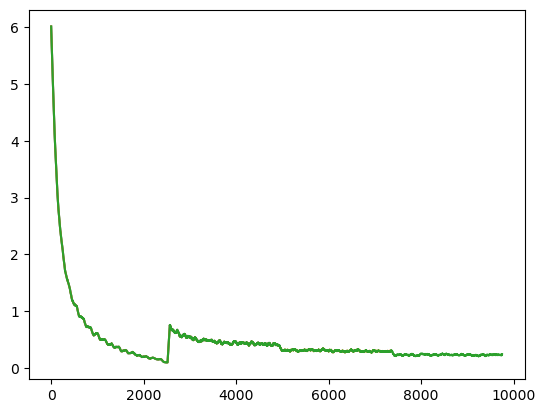

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import itertools
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models import resnet50, ResNet50_Weights

### set up directories
prev_cpts = '/kaggle/input/restartdata/'
checkpoints = '/kaggle/working/'

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

def create_transforms(input_size=128, horizontal_flip_prob=0, vertical_flip_prob=0, color_jitter_prob=0, \
                      brightness_prob=0, contrast_prob=0, saturation_prob=0, hue_prob=0):
    transform_list = [
        transforms.Resize(input_size),
        transforms.RandomCrop(input_size, padding=8, padding_mode='edge'),
        transforms.ToTensor(),
    ]
    
    if horizontal_flip_prob > 0:
        transform_list.append(transforms.RandomHorizontalFlip(p=horizontal_flip_prob))
    
    if vertical_flip_prob > 0:
        transform_list.append(transforms.RandomVerticalFlip(p=vertical_flip_prob))
    
    if (brightness_prob + contrast_prob + saturation_prob + hue_prob) > 0:
        transform_list.append(transforms.ColorJitter(brightness=brightness_prob, contrast=contrast_prob,
                                                     saturation=saturation_prob, hue=hue_prob))
    
    return transforms.Compose(transform_list)

def get_bird_data(augmentation=0, input_size=128):
    transform_original = create_transforms(input_size=input_size)
    transform_hor = create_transforms(input_size=input_size, horizontal_flip_prob=1)
    transform_ver = create_transforms(input_size=input_size, vertical_flip_prob=1)
    transform_jitter = create_transforms(input_size=input_size, saturation_prob=0.5)
    
    
    transform_test = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
    ])
    
    

    data_path = '/kaggle/input/birds23sp/birds/'

    trainset = torch.utils.data.ConcatDataset( [
                    torchvision.datasets.ImageFolder(root=data_path + 'train', transform=transform_original), \
                    torchvision.datasets.ImageFolder(root=data_path + 'train', transform=transform_hor), \
                    torchvision.datasets.ImageFolder(root=data_path + 'train', transform=transform_ver), \
                    torchvision.datasets.ImageFolder(root=data_path + 'train', transform=transform_jitter)
                ])
    
    testset = torchvision.datasets.ImageFolder(root=data_path + 'test', transform=transform_test)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    
    
    classes = open(data_path + "names.txt").read().strip().split("\n")
    class_to_idx = trainset.datasets[0].class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.90, decay=0.0005, 
          verbose=1, print_every=10, state=None, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    #optimizer = optim.RMSprop(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    #adam
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='abs')

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
#     for epoch in range(start_epoch):
#         if epoch in schedule:
#             print ("Learning rate: %f"% schedule[epoch])
#             for g in optimizer.param_groups:
#                 g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0
        
        for g in optimizer.param_groups:
                print ("Learning rate: %f"% g['lr'])

        # Update learning rate when scheduled
#         if epoch in schedule:
#             print ("Learning rate: %f"% schedule[epoch])
#             for g in optimizer.param_groups:
#                 g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction
            

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        scheduler.step(sum_loss)
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'retrain-checkpoint-%d.pkl'%(epoch+1))
            plt.plot(smooth(state['losses'], 50))
            plt.savefig('checkpoint-%d.png'%(epoch+1))
    return losses

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
data = get_bird_data(input_size=256)
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', weights=ResNet34_Weights.IMAGENET1K_V1)
resnet.fc = nn.Linear(512, 555)

# selectable between starting at a checkpoint or from scratch.
if (1):
    state = torch.load(prev_cpts + 'plateau_checkpoint-17.pkl')
    resnet.load_state_dict(state['net'])
    losses = train(resnet, data['train'], epochs=20, lr=.01, print_every=10, checkpoint_path=checkpoints, state=state)
else: 
    losses = train(resnet, data['train'], epochs=25, lr=.01, print_every=10, checkpoint_path=checkpoints)

In [2]:

def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()


if (0):
    state = torch.load('/kaggle/input/restartdata/resnet50-checkpoint-15.pkl')
    resnet.load_state_dict(state['net'])
    predict(resnet, data['test'], checkpoints + "preds_res50.csv")